In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pickle

from counterfactualgp.bsplines import BSplines
from counterfactualgp.lmm import LinearMixedModel, learn_lmm

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = data['xlim']
num_basis = 5
bsplines_degree = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')

In [4]:
n_train = data['n_train']
samples = [(y,basis.design(x),basis.design(x)) for y,x in data['samples'][:n_train]]

In [5]:
lmm = learn_lmm(samples)

In [6]:
truncated_time = data['truncated_time']
samples_star = [(y[x<truncated_time],basis.design(x)[x<truncated_time],basis.design(x)[x<truncated_time]) 
                for y,x in data['samples'][n_train:]]
samples_test = [(y,x) for y,x in data['samples'][n_train:]]

In [7]:
def draw_lmm_prediction(lmm, samples_star, samples_test, nrow=3, ncol=3, truncated_time=None):
    beta, Sigma, v = lmm.param_copy()

    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12,8), sharex=True, sharey=True)
    for idx, (ss, st) in enumerate(zip(samples_star, samples_test)):
        if idx == nrow*ncol: break
        r = idx // nrow
        c = idx % nrow
            
        y,x,z = ss
        yt,tt = st
        
        m, S = lmm.posterior(y,x,z)
        
        tp = np.linspace(low, high, num=100)
        yhat = np.dot(basis.design(tp), m) + np.dot(basis.design(tp), beta)

        axes[r,c].plot(tp, yhat)
        axes[r,c].scatter(tt, yt)
        if truncated_time:
            axes[r,c].axvline(x=truncated_time, color='r', ls='--')
    plt.show()

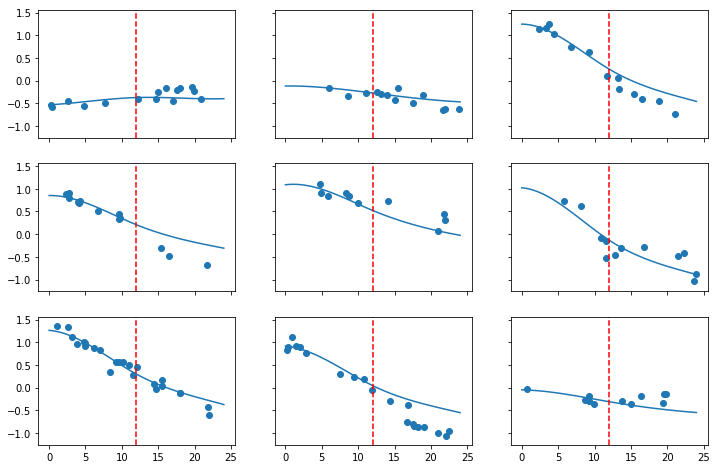

In [8]:
draw_lmm_prediction(lmm, samples_star, samples_test, 3, 3, truncated_time)